In [21]:
import os
import shutil

source_dir = "C:/Users/User/Documents/sem 2 y3/ML/project/WFDD"
target_dir = 'fabric_classification_dataset'

# Create target folders
os.makedirs(os.path.join(target_dir, 'good'), exist_ok=True)
os.makedirs(os.path.join(target_dir, 'defect'), exist_ok=True)

# Loop through each cloth type (e.g., grey cloth, grid cloth, etc.)
for cloth in os.listdir(source_dir):
    cloth_path = os.path.join(source_dir, cloth)
    
    # -------- GOOD IMAGES --------
    for good_subfolder in ['train/good', 'test/good']:
        good_path = os.path.join(cloth_path, good_subfolder)
        if os.path.exists(good_path):
            for file in os.listdir(good_path):
                src = os.path.join(good_path, file)
                dst = os.path.join(target_dir, 'good', f"{cloth}_{file}")
                shutil.copy(src, dst)

    # -------- DEFECT IMAGES --------
    test_path = os.path.join(cloth_path, 'test')
    if os.path.exists(test_path):
        for sub in os.listdir(test_path):
            sub_path = os.path.join(test_path, sub)

            if os.path.isdir(sub_path) and sub.lower() not in ['good']:
                # It's a defect folder like contaminated, flecked, etc.
                for file in os.listdir(sub_path):
                    src = os.path.join(sub_path, file)
                    dst = os.path.join(target_dir, 'defect', f"{cloth}_{sub}_{file}")
                    shutil.copy(src, dst)



In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, Reshape, Conv2D, Multiply, Add
import tensorflow.keras.backend as K

def coordinate_attention(inputs, reduction=32):
    h, w, c = inputs.shape[1:]

    # Average pooling along spatial dimensions
    avg_pool_h = tf.reduce_mean(inputs, axis=2, keepdims=True)
    avg_pool_w = tf.reduce_mean(inputs, axis=1, keepdims=True)

    avg_pool_h = Reshape((h, 1, c))(avg_pool_h)
    avg_pool_w = Reshape((1, w, c))(avg_pool_w)

    concat = Add()([avg_pool_h, avg_pool_w])
    reduced = Conv2D(c // reduction, kernel_size=1, activation='relu', padding='same')(concat)

    attn_h = Conv2D(c, kernel_size=1, activation='sigmoid', padding='same')(reduced)
    attn_w = Conv2D(c, kernel_size=1, activation='sigmoid', padding='same')(reduced)

    out = Multiply()([inputs, attn_h, attn_w])
    return out


In [25]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

def build_resnet50_with_ca(input_shape=(224, 224, 3)):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # freeze pretrained layers

    x = base_model.output
    x = coordinate_attention(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model


In [26]:
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights_dict = dict(enumerate(class_weights))

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_dir = 'fabric_classification_dataset'
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 3265 images belonging to 2 classes.
Found 815 images belonging to 2 classes.


In [28]:
print("Total GOOD images:", len(os.listdir(os.path.join(target_dir, 'good'))))
print("Total DEFECT images:", len(os.listdir(os.path.join(target_dir, 'defect'))))


Total GOOD images: 3657
Total DEFECT images: 423


In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [30]:
model = build_resnet50_with_ca(input_shape=img_size + (3,))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)


Epoch 1/10
103/103 [==============================] - 313s 3s/step - loss: 0.6652 - accuracy: 0.6083 - val_loss: 0.6209 - val_accuracy: 0.6086
Epoch 2/10
103/103 [==============================] - 281s 3s/step - loss: 0.6440 - accuracy: 0.5911 - val_loss: 0.6539 - val_accuracy: 0.6074
Epoch 3/10
103/103 [==============================] - 282s 3s/step - loss: 0.6358 - accuracy: 0.5850 - val_loss: 0.6150 - val_accuracy: 0.6086
Epoch 4/10
103/103 [==============================] - 279s 3s/step - loss: 0.6334 - accuracy: 0.5822 - val_loss: 0.6512 - val_accuracy: 0.6049
Epoch 5/10
103/103 [==============================] - 281s 3s/step - loss: 0.6281 - accuracy: 0.5841 - val_loss: 0.6229 - val_accuracy: 0.6074
Epoch 6/10
103/103 [==============================] - 282s 3s/step - loss: 0.6315 - accuracy: 0.5749 - val_loss: 0.5990 - val_accuracy: 0.6086
Epoch 7/10
103/103 [==============================] - 284s 3s/step - loss: 0.6244 - accuracy: 0.5807 - val_loss: 0.5749 - val_accuracy: 0.6086

In [31]:
# Unfreeze base model
model.layers[0].trainable = True

# Re-compile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Continue training with callback
model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)


Epoch 1/5
103/103 [==============================] - 286s 3s/step - loss: 0.6257 - accuracy: 0.5847 - val_loss: 0.5777 - val_accuracy: 0.6086
Epoch 2/5
103/103 [==============================] - 281s 3s/step - loss: 0.6190 - accuracy: 0.5853 - val_loss: 0.5783 - val_accuracy: 0.6086
Epoch 3/5
103/103 [==============================] - 280s 3s/step - loss: 0.6229 - accuracy: 0.5859 - val_loss: 0.5831 - val_accuracy: 0.6074
Epoch 4/5
103/103 [==============================] - 282s 3s/step - loss: 0.6210 - accuracy: 0.5859 - val_loss: 0.5820 - val_accuracy: 0.6074


In [32]:
from sklearn.metrics import classification_report
import numpy as np

val_gen.reset()
preds = model.predict(val_gen)
y_pred = (preds > 0.5).astype(int).flatten()
y_true = val_gen.classes

print(classification_report(y_true, y_pred, target_names=['Good', 'Defect']))


26/26 [==============================] - 54s 2s/step
              precision    recall  f1-score   support

        Good       0.17      0.73      0.28        84
      Defect       0.95      0.60      0.73       731

    accuracy                           0.61       815
   macro avg       0.56      0.66      0.50       815
weighted avg       0.87      0.61      0.68       815



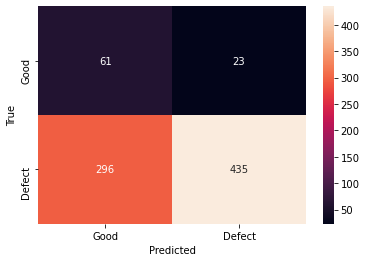

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Good', 'Defect'], yticklabels=['Good', 'Defect'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
